# Tagging

Tagging is the mechanism by which we can annotate points or regions in recorded data.

![data model](resources/tag1.png)

For example, at some point a stimulus is switched on and the system's response to the stimulus is recorded.

To define this region we need to specify the starting point and the extent (in this example, the duration) of the stimulus-on time.

![data model](resources/tag2.png)

Translated to NIX we have:

1. The **DataArray** that stores the *response* data
2. The starting point (time) of stimulus onset
3. The stimulus duration

## Tag

The **Tag** entity stores this information and links it to the recorded data:


In [1]:
import nixio
import numpy as np
import scipy.signal as signal

def butter_lowpass(highcut, fs, order=5):
    """creates a butterworth lowpass filter.

    Args:
        highcut (double): the cutoff frequency in Hz
        fs (int): the sampling rate of the data
        order (int, optional): the order of the low-pass filter. Defaults to 5.

    Returns:
        b, a (np.array): the filter coefficients
    """
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='low')

    return b, a

def butter_highpass(lowcut, fs, order=5):
    """creates a butterworth highpass filter.

    Args:
        highcut (double): the cutoff frequency in Hz
        fs (int): the sampling rate of the data
        order (int, optional): the order of the low-pass filter. Defaults to 5.

    Returns:
        b, a (np.array): the filter coefficients
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='high')

    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, lporder=1, hporder=1):
    """ Applies an butterworth bandpass filter to the data. 
    Args:
        data: the data that should be filtered. Must be one dimensional.
        lowcut (double): the lowpass cutoff frequency in Hz
        highcut (double): the highpass filter cutoff frequency in Hz.
        fs (int): the sampling frequency of the data.
        lporder (int): the order of the lowpass filter. Defaults to 1.
        hporder (int): the order of the highpass filter. Defaults to 1.
    
    Returns:
        y (np.array): the filtered data.
    """
    data = np.squeeze(data)
    if len(data.shape) > 1:
        raise ValueError("data must be 1-D!")
    
    lpb, lpa = butter_lowpass(highcut, fs, order=lporder)
    hpb, hpa = butter_highpass(lowcut, fs, order=hporder)
    y = signal.lfilter(lpb, lpa, data)
    y = signal.lfilter(hpb, hpa, y)

    return y

def create_data(duration, dt, stim_on, stim_off, stim_amplitude):
    time = np.arange(0., duration, dt)
    stimulus = np.zeros(time.shape)
    stimulus[(time >= stim_on) & (time < stim_off)] = stim_amplitude
    response = butter_bandpass_filter(stimulus, .25, 10., 1. / dt)

    return time, stimulus, response


def main():
    interval = 0.001
    duration = 3.5
    stim_on = 0.5
    stim_off = 2.5
    stim_amplitude = 1.0

    time, _, response = create_data(duration, interval, stim_on, stim_off, stim_amplitude)

    nixfile = nixio.File.open("tagging1.nix", nixio.FileMode.Overwrite)
    block = nixfile.create_block("demo block", "nix.session")

    # *********  This is the interesting part **********
    data = block.create_data_array("response", "nix.sampled", data=response, label="voltage", unit="mV")
    data.append_sampled_dimension(interval, label="time", unit="s")

    stim_tag = block.create_tag("stimulus", "nix.stimulus_segment", position=[stim_on])
    stim_tag.extent = [stim_off - stim_on]
    stim_tag.references.append(data)
    # **************************************************
    nixfile.close()

main()

The **Tag** is created with the *position*, and is given the *extent* to the stimulus-on segment. It "refers" to the response data. 

**Notes:**

1. **Tags** can tag points or segments in several **DataArrays** at once, hence they store a list of *references*. 
2. The data might be n-dimensional therefore *position* and *extent* need to be lists (one entry for each dimension).

## Reading tagged data

Tagging alone is nice, but we may want to work with the data dring the stimulus-on period, that is, we need to read it from file.


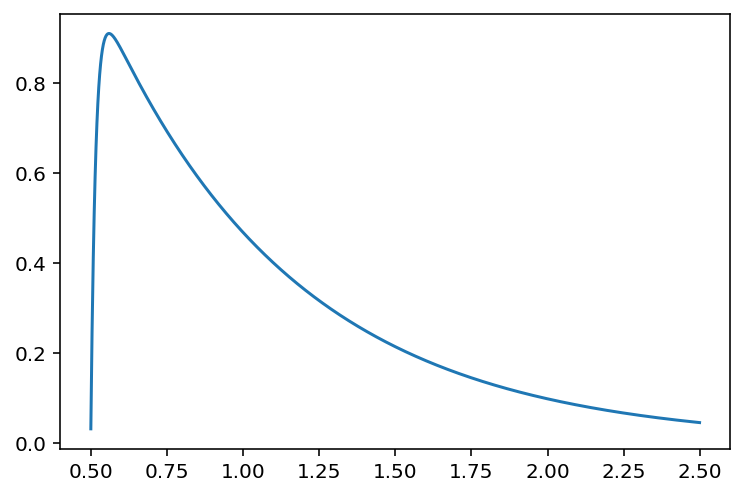

In [3]:
import nixio

%config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display
import matplotlib.pyplot as plt
%matplotlib inline

nixfile = nixio.File.open("tagging1.nix", nixio.FileMode.ReadOnly)
block = nixfile.blocks[0]

stimulus_tag = block.tags["stimulus"]
stimulus_response_data = stimulus_tag.tagged_data("response")[:]
time = stimulus_tag.references["response"].dimensions[0].axis(len(stimulus_response_data), start_position=stimulus_tag.position[0])

plt.plot(time, stimulus_response_data)
nixfile.close()

**Tags** work in the unit of the data, respectively its dimension. It is, however, possible to provide diverging units to the **Tag**.

```
    # *********  This is the interesting part **********
    data = block.create_data_array("response", "nix.sampled", data=response, label="voltage", unit="mV")
    data.append_sampled_dimension(interval, label="time", unit="s")  # dimension is defined in seconds

    stim_tag = block.create_tag("stimulus", "nix.stimulus_segment", position=[stim_on * 1000])
    stim_tag.extent = [(stim_off - stim_on) * 1000]
    stim_tag.units = ["ms"]  # the tag is specified in milli seconds
    stim_tag.references.append(data)
    # **************************************************
```

Retrieving the tagged data works regardless. Units are scaled and handled transparently by the library. 

**Note:** This works only for SI units.

## Tagging in 2-D (and n-D)

The same mechanism extends to n-dimensions. In this case the **Tag's** position and extent have to be lists of the length n.

![2dtag](resources/2d_tag.png)

With this we can create a "Region of Interest" (ROI) for example in image data. Image data is usually 3-D with the dimensions representing height, width and the three (sometimes four) color channels

![roi](resources/single_roi.png)

>  "Lenna" by Original full portrait: "Playmate of the Month". Playboy
>  Magazine. November 1972, photographed by Dwight Hooker.This 512x512
>  electronic/mechanical scan of a section of the full portrait:
>  Alexander Sawchuk and two others[1] - The USC-SIPI image
>  database. Via Wikipedia -
>  http://en.wikipedia.org/wiki/File:Lenna.png#mediaviewer/File:Lenna.png

In [ ]:
import os
from PIL import Image as img


def load_image():
    image = img.open(os.path.join("resources", "lenna.png"))
    pix = np.array(image)
    channels = list(image.mode)
    return pix, channels


img_data, channels = load_image()

# create a new file overwriting any existing content
file_name = 'single_roi.nix'
nixfile = nixio.File.open(file_name, nixio.FileMode.Overwrite)
block = nixfile.create_block("session 1", "nix.session")

data = block.create_data_array("lenna", "nix.image.rgb", data=img_data)
# add descriptors for width, height and channels
data.append_sampled_dimension(1, label="height")
data.append_sampled_dimension(1, label="width")
data.append_set_dimension(labels=channels)

# create a Tag, position and extent must be 3-D since the data is 3-D
position = [250, 250, 0]
extent = [30, 100, 3]
tag = block.create_tag('Region of interest', 'nix.roi', position)
tag.extent = extent
tag.references.append(data)

nixfile.close()

## Tagging multiple points or segments

Sometimes we do not only want to tag single points, segments or regions but sets of such. In the following situation a signal has been recorded and within this signal certain events, threshold crossings have been detected (figure below).

![multiple points](resources/multiple_points.png)

For storing this kind of data we need two **DataArrays**, the first stores the recorded signal, the other the events. Finally, a **MultiTag** entity is used to link both. One can use the event times stored in one of the DataArrays to tag multiple points in the other signal.

``` python
    signal_array = block.create_data_array("signal", "nix.sampled", data=signal, label="voltage", unit="mV")
    signal_array.append_sampled_dimension(sampling_interval, label="time", unit="s")

    event_array = block.create_data_array("threshold crossings", "nix.events.threshold_crossings", data=events, label="time", unit="s")
    event_array.append_range_dimension_using_self()

    mtag = block.create_multi_tag("event tag", "nix.tag.events", event_array)
    mtag.references.append(signal_array)
```

## Tagging multiple segments

A very similar approach is taken for tagging multiple segments in which, for example, a stimulus was switched on.

![multiple regions](resources/multiple_regions.png)

For storing such data we again need one **DataArray** to store the recorded signal. Storing the regions is similar to the approach for the simpler Tag, i.e. positions and the extents need to be provided. Accordingly, two additional **DataArrays** are required. The first of which stores the positions and the second the extents of the tagged regions.

```python
    block = nixfile.create_block("multiple regions", "nix.session")

    data_array = block.create_data_array("signal", "nix.data.sampled", data=signal)
    data_array.label = "voltage"
    data_array.unit = "mV"
    data_array.append_sampled_dimension(sampling_interval, label="time", unit="s")

    positions = block.create_data_array("stimulus onsets", "nix.region.onsets", data=stim_onsets)
    positions.append_set_dimension()

    extents = block.create_data_array("stimulus extents", "nix.region.extents", data=stim_extents)
    extents.append_set_dimension()

    mtag = block.create_multi_tag("stimulus segments", "nix.segments.stimulus", positions=positions, extents=extents)
    mtag.references.append(data_array)
```


## Tagging in n-d

The same principle as demonstrated above applies also to n-dimensional data. Tagging in n dimensions requires positions and extents stored in DataArrays of appropriate shapes.

The following figures show the tagging of multiple regions in 2- and 3-D.

![tagging 2d](resources/2d_mtag.png)

Tagging multiple regions in n-D data requires the DataArrays for storing positions and extents to be two-dimensional. The first dimension represents the number of regions, the second has as many entries as the referenced data has dimensions.

According to the number of dimensions of the data (here, width and height) each starting point and the extent of a tagged region is defined by two numbers. Thus, the position and extent DataArrays are two dimensional. The first dimension represents the number of tagged regions, the second the number of dimensions.

This approach can be extended into n-D. The following figure illustrates the 3-D case.

![tagging 3d](resources/3d_mtag.png)

 Again, the **DataArrays** for positions and extents are always 2-D, the first dimension represents the number of tagged regions, the second the number of dimensions.


## Time for a break and some exercises